In [1]:
'''
SEIRS-CoV-2 Model Proof-of-Concept Notebook
Author: Eric Renart
Last Update: 08/15/2021
'''

import numpy as np
import pandas as pd
import seaborn as sbn
from scipy.integrate import solve_ivp, odeint
from matplotlib import pyplot as pp
from sklearn.linear_model import LinearRegression

In [2]:
def ode_function(Y, t, rates, probabilities):
    S, E, A, I, H, ICU, VENT, D, R, VAX = Y
    beta, gamma, gamma_H, gamma_ICU, gamma_VENT, delta, delta_H, delta_ICU, delta_VENT, delta_D, phi, omega, lambda_mu = rates
    P_asymptomatic, P_H_from_I, P_ICU_from_H, P_VENT_from_ICU, P_D_from_VENT, P_INIT_VAX = probabilities
    N = S + E + A + I + H + ICU + VENT + D + R + VAX

    # Calculate inverse probabilities
    P_R_from_I = 1 - P_H_from_I
    P_R_from_H = 1 - P_ICU_from_H
    P_R_from_ICU = 1 - P_VENT_from_ICU
    P_R_from_VENT = 1 - P_D_from_VENT
    P_symptomatic = 1 - P_asymptomatic

    '''
    Differential ODE's
    Assumptions:
    1. Birth and Death rates are equal (LAMBDA = mu)
    2. Everyone is ventilated in ICU before dying (ie. no excess deaths apart from natural deathrate)
    3. People can only get vaccinated when susceptible or recovered
    4. Probabilities do not depend on age (Age-dependence TBI)
    5. Vaccines are 100% effective (effects of VOCs TBI)
    '''

    S_over_N = S / N
    total_I = I + A # Symptomatics and asymptomatics are both infectious
    dSdt = lambda_mu - (lambda_mu * S) - (beta * total_I * S_over_N) - (phi * P_INIT_VAX * S) + (omega * R)
    dEdt = (beta * total_I * S_over_N) - delta * (P_asymptomatic * A - P_symptomatic * I)
    dAdt = (delta * P_asymptomatic * E) - (gamma * A)
    dIdt = (delta * P_symptomatic * E) - (delta_H * P_H_from_I * I) - (gamma * P_R_from_I * I)
    dHdt = (delta_H * P_H_from_I * I) - (delta_ICU * P_ICU_from_H * H) - (gamma_H * P_R_from_H * H)
    dICUdt = (delta_ICU * P_ICU_from_H * H) - (delta_VENT * P_VENT_from_ICU * ICU) - (gamma_ICU * P_R_from_ICU * ICU)
    dVENTdt = (delta_VENT * P_VENT_from_ICU * ICU) - (delta_D * P_D_from_VENT * VENT) - (gamma_VENT * P_R_from_VENT * VENT)
    dDdt = delta_D * P_D_from_VENT * VENT
    dRdt = (gamma * total_I) + (gamma_H * H) + (gamma_ICU * ICU) + (gamma_VENT * VENT) - (omega * R) - (phi * P_INIT_VAX * R)
    dVAXdt = phi * P_INIT_VAX * (S + R)

    return (dSdt, dEdt, dAdt, dIdt, dHdt, dICUdt, dVENTdt, dDdt, dRdt, dVAXdt)


In [7]:
def run(initials, probabilities, rates, length):
    t = np.linspace(0,length,length)
    results_ts = odeint(ode_function, initials, t, args=(probabilities, rates))
    results_df = pd.DataFrame({'t': t, 'Susceptible': results_ts[:,0], 'Exposed': results_ts[:,1], 'Asymptomatic': results_ts[:,2], 'Symptomatic': results_ts[:,3],'Hospitalized': results_ts[:,4], 'ICU': results_ts[:,5], 'Ventilated': results_ts[:,6], 'Dead': results_ts[:,7], 'Recovered': results_ts[:,8], 'Vaccinated': results_ts[:,9]}, dtype='int32')
    results_df['Total N'] = results_df.sum(axis=1)
    results_df['Active Cases'] = results_df['Exposed'] + results_df['Asymptomatic'] + results_df['Symptomatic'] + results_df['Hospitalized'] + results_df['ICU'] + results_df['Ventilated']
    return results_df

In [8]:
# Virus parameters

# R0. TODO: use current R0 from CAN
R0_base = 1.3

# Natural Birth+Death Rate per day
birth_death_rate = 100

# Times
t_incubation = 5 # Incubation Period from infection to symptoms if they appear
t_symptomatic_to_hospitalized = 7
t_hospitalized_to_icu = 7
t_icu_to_ventilator = 2
t_ventilator_to_dead = 7
t_mild_asymptomatic_to_recovered = 7
t_hospitalized_to_recovered = 10
t_icu_to_recovered = 15
t_ventilated_to_recovered = 17
t_immunity_loss = 360
t_vaccine_immunity = 56

# Probabilities
p_asymptomatic = 0.35
p_symptomatic_to_hospitalized = 0.15
p_hospitalized_to_icu = 0.20
p_icu_to_ventilator = 0.55
p_ventilator_to_dead = 0.80
vaccine_hesitance = 0.25

# Construct the inputs to model
gamma = 1 / t_mild_asymptomatic_to_recovered
beta = R0_base * gamma

# Calculate rates of state transitions
rates = [beta, gamma, 1/t_hospitalized_to_recovered, 1/t_icu_to_recovered, 1/t_ventilated_to_recovered, 1/t_incubation, 1/t_symptomatic_to_hospitalized, 1/t_hospitalized_to_icu, 1/t_icu_to_ventilator, 1/t_ventilator_to_dead, 1/t_vaccine_immunity, 1/t_immunity_loss, 1/birth_death_rate]

# Probabilities of state transitions
probabilities = [p_asymptomatic, p_symptomatic_to_hospitalized, p_hospitalized_to_icu, p_icu_to_ventilator, p_ventilator_to_dead, 1-vaccine_hesitance]

In [9]:
# Initial populatiion conditions
S0 = 999999
E0 = 1
A0 = 0
I0 = 0
H0 = 0
ICU0 = 0
VENT0 = 0
D0 = 0
R0 = 0
VAX0 = 0
initials = [S0, E0, A0, I0, H0, ICU0, VENT0, D0, R0, VAX0]

In [10]:
# Run model
sim_length = 360
results = run(initials, rates, probabilities, sim_length)
results

,t,Susceptible,Exposed,Asymptomatic,Symptomatic,Hospitalized,ICU,Ventilated,Dead,Recovered,Vaccinated,Total N,Active Cases
0,0.000000,9.999990e+05,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+06,1.000000e+00
1,1.002786,9.768140e+05,1.023506e+00,6.593587e-02,1.224523e-01,1.293647e-03,1.167812e-05,8.062426e-07,1.888392e-08,1.372836e-02,1.327385e+04,9.900901e+05,1.213201e+00
2,2.005571,9.541665e+05,1.090261e+00,1.260835e-01,2.341550e-01,4.823385e-03,8.218403e-05,1.133435e-05,5.425971e-07,5.294392e-02,2.623995e+04,9.804100e+05,1.455417e+00
3,3.008357,9.320441e+05,1.196634e+00,1.839086e-01,3.415446e-01,1.020876e-02,2.459101e-04,5.067737e-05,3.712554e-06,1.158257e-01,3.890543e+04,9.709544e+05,1.732592e+00
4,4.011142,9.104345e+05,1.341211e+00,2.422542e-01,4.499007e-01,1.722684e-02,5.209245e-04,1.422070e-04,1.415142e-05,2.018275e-01,5.127726e+04,9.617180e+05,2.051256e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,355.988858,1.476474e+10,3.403243e+11,1.170311e+11,2.173434e+11,2.751387e+10,2.149596e+09,3.165367e+09,5.959576e+09,6.614694e+11,1.492008e+11,1.538922e+12,7.075276e+11
356,356.991643,1.569139e+10,3.616836e+11,1.243761e+11,2.309842e+11,2.924069e+10,2.284508e+09,3.364030e+09,6.333608e+09,7.029843e+11,1.585648e+11,1.635507e+12,7.519331e+11
357,357.994429,1.667621e+10,3.843834e+11,1.321821e+11,2.454811e+11,3.107588e+10,2.427887e+09,3.575162e+09,6.731115e+09,7.471047e+11,1.685166e+11,1.738154e+12,7.991256e+11
358,358.997214,1.772283e+10,4.085079e+11,1.404781e+11,2.608879e+11,3.302625e+10,2.580265e+09,3.799544e+09,7.153570e+09,7.939941e+11,1.790929e+11,1.847243e+12,8.492799e+11


In [50]:
def plot(results_df):
    fig, ax = pp.subplots(figsize=(12,8))
    t = results_df['t']
    ax.plot(t, results_df['Susceptible'], label='Susceptible', color='blue')
    ax.plot(t, results_df['Exposed'], label='Exposed', color='yellow')
    ax.plot(t, results_df['Asymptomatic'], label='Asymptomatic', color='pink')
    ax.plot(t, results_df['Symptomatic'], label='Symptomatic', color='red')
    ax.plot(t, results_df['Hospitalized'], label='Hospitalized', color='firebrick')
    ax.plot(t, results_df['ICU'], label='In ICU', color='purple')
    ax.plot(t, results_df['Ventilated'], label='On ventilator', color='hotpink')
    ax.plot(t, results_df['Dead'], label='Dead', color='black')
    ax.plot(t, results_df['Total N'], label='Total N', color='gray', linestyle='-') #For debug
    ax.legend()

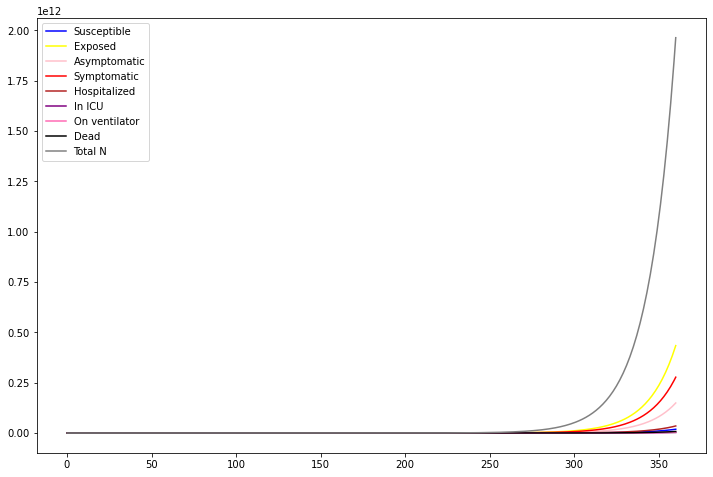

In [51]:
plot(results)